# Background

The primary reference for this notebook is the scikit-survival library - https://scikit-survival.readthedocs.io/en/stable/user_guide/00-introduction.html

As hinted by the PDF provided, a brief survival analysis of the data is implemented in this notebook section

# Survival Analysis

## Environment Setup

Install & Import necessary packages

### Install Packages

For this notebook to run properly, you'll need to have the right Python packages installed. The required packages are mlflow, scikit-survival, matplotlib, eli5 and ipykernel. 
Below is the list of command I used to create a conda environment from which I tested this notebook.


Create and activate new conda environment
```
conda update conda
conda create -n plane_parts_survival_mlflow python=3
conda activate plane_parts_survival_mlflow
```
Install python packages
```
pip install mlflow
conda install -c sebp scikit-survival
conda install matplotlib
pip install eli5
conda install -c conda-forge --name plane_parts_survival_mlflow ipykernel -y
```

### Imports

In [77]:
import os
import eli5
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from eli5.sklearn import PermutationImportance
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.nonparametric import kaplan_meier_estimator
from IPython.display import display

random_state = 369
np.random.seed(random_state) 

## Load Data

### Function Declarations

In [36]:
def load_data(data_dir):
  data_files = [os.path.join(data_dir, name) for name in os.listdir(data_dir) if ".csv" in name]
  dataframes = {}
  for filepath in data_files:
    df = pd.read_csv(filepath)
    key = os.path.basename(filepath.split(".csv")[0])
    dataframes[key] = df

  return dataframes, data_files

In [37]:
def get_num_unique(df, column_name):
    all_vals = list(df[column_name])
    unique = set(all_vals)
    conversion_map = {value:i for i, value in enumerate(unique)}
    return len(conversion_map)

In [38]:
def to_categorical(df, to_cat_cols):  
  for column in to_cat_cols:
    all_vals = list(df[column])
    unique = set(all_vals)
    conversion_map = {value:i for i, value in enumerate(unique)}
    # TODO: save conversion maps to config files (JSON)
    def _to_number(x):
      return conversion_map[x]

    df[column] = df[column].apply(_to_number)

  return df

In [39]:
def to_datetime(df, to_datetime_cols):
  for column in to_datetime_cols:
    df[column] = pd.to_datetime(df[column])
  return df

### Loading Script

In [40]:
filepath = "train\\removals\\removals.csv"
df = pd.read_csv(filepath)
display(df)

print("Number of unique values in each column:")
num_unique_values = {column_name:get_num_unique(df, column_name=column_name) for column_name in df.columns}
display(num_unique_values)


,OPERATOR_CD,AIRCRAFT_CD,FLEET_CD,CHAPTER_CD,PART_GROUP_CD,PART_NUMBER,SERIAL_NUMBER,INSTALL_DT,REMOVAL_DT,REMOVED_BOOL,AIRCRAFT_AGE,REPETITIVE_FAULT_QT,MEL_QTY,DELAY_QTY,TIME_SINCE_INSTALL_CYCLES,TIME_SINCE_NEW_CYCLES
0,VST,479,737,27,WUQ009ZB,J47SA7GA3O,SATOCLV,2/16/2019 02:31:00 PM,2/16/2019,1,22,0,NaN,NaN,0,0
1,VST,478,737,23,UV1QK3PU,VCFF5E1530,SJBEPWN,6/13/2016 02:54:51 PM,10/9/2018,1,16,9,366.0,74.0,2325,2410
2,VST,478,737,34,70J139RY,INMPMQTE8V,S49E8WE,2/23/2019 04:42:00 PM,2/25/2019,1,18,1,1.0,1.0,8,8
3,VST,479,737,46,2562CGF4,6HAG5HHU8K,S3TRZMY,10/11/2016 11:32:53 PM,10/26/2016,1,19,2,7.0,3.0,24,37
4,VST,479,737,22,ZPYPBIS7,Y4OG6SEB7W,SK7M6J3,5/10/2017 07:57:00 AM,5/11/2017,1,20,1,NaN,NaN,6,185772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10318,JUE,763,737,71,5DMQERH0,V7I9UECP27,SD10HOQ,12/4/2018,9/30/2020,0,19,0,94.0,7.0,0,0
10319,VST,955,737,71,5DMQERH0,V7I9UECP27,SJL6RK3,11/5/2017,9/30/2020,0,18,3,301.0,7.0,1850,1850
10320,JUE,763,737,71,5DMQERH0,V7I9UECP27,SK4FE32,11/10/2017,9/30/2020,0,18,0,270.0,14.0,1210,1210
10321,VST,478,737,71,5DMQERH0,V7I9UECP27,SKTVO79,5/11/2017,9/30/2020,0,17,0,289.0,33.0,2013,2013


Number of unique values in each column:


{'OPERATOR_CD': 2,
 'AIRCRAFT_CD': 10,
 'FLEET_CD': 2,
 'CHAPTER_CD': 39,
 'PART_GROUP_CD': 732,
 'PART_NUMBER': 934,
 'SERIAL_NUMBER': 6734,
 'INSTALL_DT': 7426,
 'REMOVAL_DT': 1572,
 'REMOVED_BOOL': 2,
 'AIRCRAFT_AGE': 19,
 'REPETITIVE_FAULT_QT': 51,
 'MEL_QTY': 3509,
 'DELAY_QTY': 4256,
 'TIME_SINCE_INSTALL_CYCLES': 1912,
 'TIME_SINCE_NEW_CYCLES': 3407}

The cell outputs help us understand the data. The DataFrame ```df``` has 10323 rows which is more than the number of unique serial numbers of 6734. There some parts appear in the dataset more than once. There is 2 unique operator codes, 10 aircraft codes, 2 different fleet codes, 39 different chapter codes etc... 

From this I determined the categorical and datetime variable types and stored them in ```CATEGORICAL``` and ```DATETIME``` lists

From the README.txt (under ```removals``` folder), I determined the boolean event variable ```EVENT``` and the observed survival time ```EVENT_TIME```

In [41]:
# TODO: Setup as API calls? Could be included in a web interface for users to specify....
CATEGORICAL = ["OPERATOR_CD", "AIRCRAFT_CD", "FLEET_CD", "CHAPTER_CD", "PART_GROUP_CD", "PART_NUMBER", "SERIAL_NUMBER"]
DATETIME = ['INSTALL_DT', 'REMOVAL_DT']
EVENT = "REMOVED_BOOL"
EVENT_TIME = "TIME_SINCE_NEW_CYCLES"

df = to_categorical(df, CATEGORICAL)
df = to_datetime(df, DATETIME)

### Datetime feature engineerng

https://towardsdatascience.com/machine-learning-with-datetime-feature-engineering-predicting-healthcare-appointment-no-shows-5e4ca3a85f96

In [42]:
def add_datetime_features(df, dt_columns):
    '''
    This function extracts datetime features from datetime pandas variables. 
    '''
    for col in dt_columns:
        df[col+"_year"] = df[col].dt.year
        df[col+"_month"] = df[col].dt.month
        df[col+"_week"] = df[col].dt.week
        df[col+"_day"] = df[col].dt.day
        df[col+"_hour"] = df[col].dt.hour
        df[col+"_minute"] = df[col].dt.minute
        df[col+"_dayofweek"] = df[col].dt.dayofweek
    return df

The number of days a part was installed can be calculated as the number of days between ```INSTALL_DT``` and ```REMOVAL_DT```

I exclude ```INSTALL_DT``` and ```REMOVAL_DT``` columns since they are not numeric values. ML models need numeric values. Also, the new engineered features can capture the seasonal effects therefore ```INSTALL_DT``` and ```REMOVAL_DT``` are now redundant.

In [43]:
df['installed_days'] = (df['REMOVAL_DT'] - df['INSTALL_DT']).dt.days.astype('int16').abs()
df = add_datetime_features(df, DATETIME)

EXCLUDE = ["SERIAL_NUMBER", "INSTALL_DT", "REMOVAL_DT", 'REMOVAL_DT_minute', 'REMOVAL_DT_hour']
df = df.drop(columns=EXCLUDE)
display(df)
display(df.iloc[:, ['installed_days', EVENT_TIME]])

C:\Users\Olivier\anaconda3\envs\plane_parts_survival_mlflow\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


,OPERATOR_CD,AIRCRAFT_CD,FLEET_CD,CHAPTER_CD,PART_GROUP_CD,PART_NUMBER,REMOVED_BOOL,AIRCRAFT_AGE,REPETITIVE_FAULT_QT,MEL_QTY,...,INSTALL_DT_week,INSTALL_DT_day,INSTALL_DT_hour,INSTALL_DT_minute,INSTALL_DT_dayofweekr,REMOVAL_DT_year,REMOVAL_DT_month,REMOVAL_DT_week,REMOVAL_DT_day,REMOVAL_DT_dayofweekr
0,0,9,0,11,641,442,1,22,0,NaN,...,7,16,14,31,5,2019,2,7,16,5
1,0,8,0,7,422,447,1,16,9,366.0,...,24,13,14,54,0,2018,10,41,9,1
2,0,8,0,18,82,359,1,18,1,1.0,...,8,23,16,42,5,2019,2,9,25,0
3,0,9,0,23,681,431,1,19,2,7.0,...,41,11,23,32,1,2016,10,43,26,2
4,0,9,0,6,255,476,1,20,1,NaN,...,19,10,7,57,2,2017,5,19,11,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10318,1,6,0,32,120,563,0,19,0,94.0,...,49,4,0,0,1,2020,9,40,30,2
10319,0,5,0,32,120,563,0,18,3,301.0,...,44,5,0,0,6,2020,9,40,30,2
10320,1,6,0,32,120,563,0,18,0,270.0,...,45,10,0,0,4,2020,9,40,30,2
10321,0,8,0,32,120,563,0,17,0,289.0,...,19,11,0,0,3,2020,9,40,30,2


In [55]:
display(df.loc[:, ['installed_days', EVENT_TIME]])
display(df.groupby("REMOVAL_DT_year").size())
display(df.groupby("REMOVAL_DT_month").size())
display(df.groupby("REMOVAL_DT_week").size())
display(df.groupby("REMOVAL_DT_dayofweek").size())

,installed_days,TIME_SINCE_NEW_CYCLES
0,1,0
1,847,2410
2,1,8
3,14,37
4,0,185772
...,...,...
10318,666,0
10319,1060,1850
10320,1055,1210
10321,1238,2013


REMOVAL_DT_year
2014     225
2015     679
2016    1871
2017    2373
2018    2009
2019    1025
2020    2141
dtype: int64

REMOVAL_DT_month
1      698
2      637
3      638
4      770
5      766
6      704
7      599
8      547
9     2873
10     753
11     544
12     794
dtype: int64

REMOVAL_DT_week
1      147
2      157
3      158
4      170
5      132
6      164
7      149
8      183
9      147
10     127
11     129
12     172
13     149
14     151
15     162
16     245
17     175
18     176
19     176
20     251
21     118
22     115
23     147
24     153
25     190
26     181
27     166
28     129
29     132
30     126
31     108
32     111
33     163
34     105
35     119
36     241
37     144
38     169
39     143
40    2292
41     159
42     157
43     226
44     133
45     116
46     121
47     147
48     138
49     177
50     196
51     189
52     174
53      18
dtype: int64

REMOVAL_DT_dayofweekr
0    1265
1    1062
2    3352
3    1006
4    1098
5    1301
6    1239
dtype: int64

Text(0.5, 0, 'time $t$')

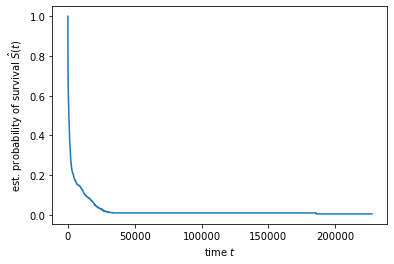

In [44]:
# x,y definition/assignment
# covariates = x
# y = (event_status, time_of_event), event_status: {0: censored/part not removed, 1: part removed}
data_y = df.loc[:, [EVENT, EVENT_TIME]]
data_y_bool = df.loc[:, [EVENT, EVENT_TIME]]
data_y_bool[EVENT] = data_y.loc[:, EVENT].astype(bool)
x = df.drop(columns=[EVENT, EVENT_TIME])

# visualize S(t)
# time, survival_prob = kaplan_meier_estimator(data_y["Status"], data_y["Survival_in_days"])
time, survival_prob = kaplan_meier_estimator(data_y_bool[EVENT], data_y_bool[EVENT_TIME])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$") # TIME_SINCE_NEW_CYCLES
plt.xlabel("time $t$")


## Train/test Split

In [46]:
# train/test split
x_train, x_test, y_train, y_test = train_test_split(x, data_y_bool, test_size=0.2, random_state=random_state)
display(x_test)

# TODO: stratify train/test by SERIAL_NUMBER? would this help or would this be considered data leak? I can imagine that some serial numbers could be associated with earlier failure cycles/rates? Maybe a faulty part release in an industrial assembly plant? Would datetime features capture this?

,OPERATOR_CD,AIRCRAFT_CD,FLEET_CD,CHAPTER_CD,PART_GROUP_CD,PART_NUMBER,AIRCRAFT_AGE,REPETITIVE_FAULT_QT,MEL_QTY,DELAY_QTY,...,INSTALL_DT_week,INSTALL_DT_day,INSTALL_DT_hour,INSTALL_DT_minute,INSTALL_DT_dayofweekr,REMOVAL_DT_year,REMOVAL_DT_month,REMOVAL_DT_week,REMOVAL_DT_day,REMOVAL_DT_dayofweekr
9775,1,3,0,12,39,633,23,0,1050.0,71.0,...,32,6,0,0,2,2020,9,40,30,2
7546,0,0,0,19,55,874,19,0,31.0,6.0,...,40,7,14,16,4,2016,12,49,5,0
253,0,9,0,11,571,288,19,0,NaN,NaN,...,36,5,21,56,0,2016,9,36,5,0
3039,1,6,0,36,190,685,18,0,NaN,NaN,...,3,16,4,30,1,2018,1,3,16,1
3950,0,8,0,11,471,507,17,0,NaN,NaN,...,42,18,12,33,2,2017,10,42,18,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8921,0,0,0,17,321,59,20,8,257.0,15.0,...,36,6,0,0,2,2020,9,40,30,2
1884,0,8,0,19,55,85,15,0,16.0,5.0,...,50,12,17,7,5,2016,1,1,7,3
5792,0,5,0,19,55,85,18,0,1.0,NaN,...,33,14,6,29,1,2018,8,33,16,3
1065,0,9,0,15,231,168,19,1,6.0,NaN,...,39,1,1,10,5,2016,10,41,11,1


## Impute missing values

In [47]:
# impute
# TODO: get list of impute columns by using isna()
impute_columns = ['MEL_QTY', 'DELAY_QTY']
imputer = SimpleImputer().fit(x_train.loc[:, impute_columns])
x_train_imputed = imputer.transform(x_train.loc[:, impute_columns])
x_train.loc[:, impute_columns] = x_train_imputed
x_test_imputed = imputer.transform(x_test.loc[:, impute_columns])
x_test.loc[:, impute_columns] = x_test_imputed

display(x_test)

,OPERATOR_CD,AIRCRAFT_CD,FLEET_CD,CHAPTER_CD,PART_GROUP_CD,PART_NUMBER,AIRCRAFT_AGE,REPETITIVE_FAULT_QT,MEL_QTY,DELAY_QTY,...,INSTALL_DT_week,INSTALL_DT_day,INSTALL_DT_hour,INSTALL_DT_minute,INSTALL_DT_dayofweekr,REMOVAL_DT_year,REMOVAL_DT_month,REMOVAL_DT_week,REMOVAL_DT_day,REMOVAL_DT_dayofweekr
9775,1,3,0,12,39,633,23,0,1050.000000,71.000000,...,32,6,0,0,2,2020,9,40,30,2
7546,0,0,0,19,55,874,19,0,31.000000,6.000000,...,40,7,14,16,4,2016,12,49,5,0
253,0,9,0,11,571,288,19,0,165.236083,19.647059,...,36,5,21,56,0,2016,9,36,5,0
3039,1,6,0,36,190,685,18,0,165.236083,19.647059,...,3,16,4,30,1,2018,1,3,16,1
3950,0,8,0,11,471,507,17,0,165.236083,19.647059,...,42,18,12,33,2,2017,10,42,18,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8921,0,0,0,17,321,59,20,8,257.000000,15.000000,...,36,6,0,0,2,2020,9,40,30,2
1884,0,8,0,19,55,85,15,0,16.000000,5.000000,...,50,12,17,7,5,2016,1,1,7,3
5792,0,5,0,19,55,85,18,0,1.000000,19.647059,...,33,14,6,29,1,2018,8,33,16,3
1065,0,9,0,15,231,168,19,1,6.000000,19.647059,...,39,1,1,10,5,2016,10,41,11,1


In [48]:
display(y_test)

,REMOVED_BOOL,TIME_SINCE_NEW_CYCLES
9775,False,3673
7546,True,10146
253,True,0
3039,True,0
3950,True,0
...,...,...
8921,False,1933
1884,True,11360
5792,True,814
1065,True,1397


## Train Model

In [49]:
rsf = RandomSurvivalForest(n_estimators=50,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=random_state)


rsf.fit(x_train, y_train.to_records(index=False))
rsf.score(x_test, y_test.to_records(index=False))

0.7413115528481224

## Permutation-based Feature Importance

In [50]:
perm = PermutationImportance(rsf, n_iter=15, random_state=random_state)
display(x_test)
perm.fit(x_test, y_test.to_records(index=False))
df_weights = eli5.explain_weights_df(perm, feature_names=x.columns.tolist())
display(df_weights)
eli5.show_weights(perm, feature_names=x.columns.tolist())


,OPERATOR_CD,AIRCRAFT_CD,FLEET_CD,CHAPTER_CD,PART_GROUP_CD,PART_NUMBER,AIRCRAFT_AGE,REPETITIVE_FAULT_QT,MEL_QTY,DELAY_QTY,...,INSTALL_DT_week,INSTALL_DT_day,INSTALL_DT_hour,INSTALL_DT_minute,INSTALL_DT_dayofweekr,REMOVAL_DT_year,REMOVAL_DT_month,REMOVAL_DT_week,REMOVAL_DT_day,REMOVAL_DT_dayofweekr
9775,1,3,0,12,39,633,23,0,1050.000000,71.000000,...,32,6,0,0,2,2020,9,40,30,2
7546,0,0,0,19,55,874,19,0,31.000000,6.000000,...,40,7,14,16,4,2016,12,49,5,0
253,0,9,0,11,571,288,19,0,165.236083,19.647059,...,36,5,21,56,0,2016,9,36,5,0
3039,1,6,0,36,190,685,18,0,165.236083,19.647059,...,3,16,4,30,1,2018,1,3,16,1
3950,0,8,0,11,471,507,17,0,165.236083,19.647059,...,42,18,12,33,2,2017,10,42,18,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8921,0,0,0,17,321,59,20,8,257.000000,15.000000,...,36,6,0,0,2,2020,9,40,30,2
1884,0,8,0,19,55,85,15,0,16.000000,5.000000,...,50,12,17,7,5,2016,1,1,7,3
5792,0,5,0,19,55,85,18,0,1.000000,19.647059,...,33,14,6,29,1,2018,8,33,16,3
1065,0,9,0,15,231,168,19,1,6.000000,19.647059,...,39,1,1,10,5,2016,10,41,11,1


Weight,Feature
0.0148 ± 0.0039,installed_days
0.0102 ± 0.0043,PART_GROUP_CD
0.0085 ± 0.0042,REMOVAL_DT_year
0.0077 ± 0.0040,CHAPTER_CD
0.0049 ± 0.0036,PART_NUMBER
0.0045 ± 0.0020,MEL_QTY
0.0038 ± 0.0018,INSTALL_DT_year
0.0032 ± 0.0017,FLEET_CD
0.0023 ± 0.0009,AIRCRAFT_AGE
0.0014 ± 0.0011,OPERATOR_CD


## Feature Selection

In [80]:
predictive_features = list(df_weights[df_weights["weight"]>0]["feature"])
print(predictive_features)

with open(os.path.join("train","predictive_features.json"), "w") as outfile:
    json.dump(predictive_features, outfile)

['installed_days', 'PART_GROUP_CD', 'REMOVAL_DT_year', 'CHAPTER_CD', 'PART_NUMBER', 'MEL_QTY', 'INSTALL_DT_year', 'FLEET_CD', 'AIRCRAFT_AGE', 'OPERATOR_CD', 'DELAY_QTY']


## Retrain model with selected/predictive features only

In [73]:
x_train_predictive = x_train.loc[:, predictive_features]
x_test_predictive = x_test.loc[:, predictive_features]
rsf_improved = RandomSurvivalForest(n_estimators=50,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=random_state)


rsf_improved.fit(x_train_predictive, y_train.to_records(index=False))
rsf_improved.score(x_test_predictive, y_test.to_records(index=False))

0.7609683302542234

,installed_days,PART_GROUP_CD,REMOVAL_DT_year,CHAPTER_CD,PART_NUMBER,MEL_QTY,INSTALL_DT_year,FLEET_CD,AIRCRAFT_AGE,OPERATOR_CD,DELAY_QTY
5957,0,3,2015,9,836,165.236083,2015,0,24,1,19.647059
572,0,55,2016,19,85,1.000000,2016,0,15,0,19.647059
7926,0,55,2016,19,85,1.000000,2016,0,16,0,19.647059
9639,2807,537,2020,18,703,165.236083,2013,0,23,1,19.647059
8976,2879,132,2020,10,274,1050.000000,2012,0,21,1,71.000000
9984,2920,290,2020,9,260,165.236083,2012,0,23,1,19.647059


0    3987.780957
1    2822.850722
2    2831.466198
3     301.881714
4      32.213916
5     287.579121
dtype: float64

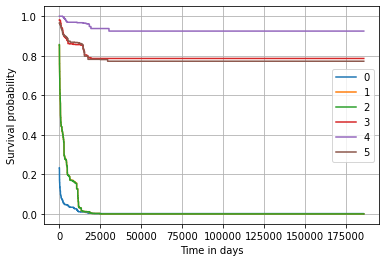

In [74]:
X_test_sorted = x_test_predictive.sort_values(by=predictive_features)
X_test_sel = pd.concat((X_test_sorted.head(3), X_test_sorted.tail(3)))
display(X_test_sel)
display(pd.Series(rsf_improved.predict(X_test_sel)))

surv = rsf_improved.predict_survival_function(X_test_sel, return_array=True)
for i, s in enumerate(surv):
    plt.step(rsf_improved.event_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in cycles")
plt.legend()
plt.grid(True)

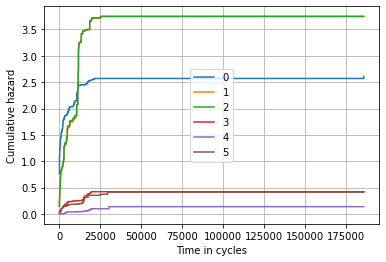

In [75]:
surv = rsf_improved.predict_cumulative_hazard_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf_improved.event_times_, s, where="post", label=str(i))
plt.ylabel("Cumulative hazard")
plt.xlabel("Time in cycles")
plt.legend()
plt.grid(True)

# Deployment with mlflow

```
mlflow run train
mlflow ui
```

Go to the mlflow ui url and fetch the model uuid

```
mlflow models serve -m runs:/my-run-id/model-path -p 1234 --no-conda

example: mlflow models serve -m runs:/7b751f0910864f93aecb22e6bfc9791b/model -p 1234 --no-conda
```

In [82]:
import requests

host = '127.0.0.1'
port = '1234'

url = f'http://{host}:{port}/invocations'

headers = {
    'Content-Type': 'application/json',
}

# test_data is a Pandas dataframe with data for testing the ML model
http_data = X_test_sel.to_json(orient='split')

r = requests.post(url=url, headers=headers, data=http_data)
print(f'Predictions: {r.text}')

Predictions: [3993.0652554069466, 3257.329251703717, 3219.250108846574, 103.02346209930421, 31.28046048396048, 149.08822755606968]


# Improvements

The following improvements can be made:

1. Model selection experiment by comparing different models and different hyperparameters. 
    1. Pytorch deep learning model references [1](https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-018-0482-1), [2](https://github.com/havakv/pycox#references), [3](https://humboldt-wi.github.io/blog/research/information_systems_1920/group2_survivalanalysis/).
    2. scikit-survival also offers Gradient Boosted Models and Survival Support Vector Machines.
2. Implement model deployment pipeline from .csv filepath. Includes preprocessing pipeline of the .csv data

# Archive

```
mlflow models build-docker -m C:\Users\Olivier\Documents\Code\IFS\mlruns\0\d2672823cb054409b7fa8b37087af4c2\artifacts\model -n sksurv_rsf_plan

mlflow models serve -m Documents\Code\IFS\mlruns\0\d2672823cb054409b7fa8b37087af4c2\artifacts\model -p 1234 --no-conda

mlflow models serve -m Documents\Code\IFS\mlruns\0\d2672823cb054409b7fa8b37087af4c2\artifacts\model -p 1234 --no-conda

mlflow models serve -m model -p 8001 --no-conda

conda env export > conda.yaml
```

In [ ]:
"C:\Users\Olivier\Documents\Code\\IFS\\mlruns\\0\\d2672823cb054409b7fa8b37087af4c2\\artifacts\\model\\"